In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from keras import metrics

from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


# Using CNN Section

## Gamma Function 
Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems.


In [2]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [23]:
data = []
gamma = 2.5
normal_count = 0
pneumonia_count = 0
img_size = 50
assign_dict = {"benign":0, "malignant":1}

def get_data(directory):
    for sub_directory in os.listdir(directory):
        if sub_directory == "malignant":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
                
        if sub_directory == "benign":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
    random.shuffle(data)  
    return np.array(data)

## Loading Dataset

In [24]:
train = get_data('./data')
val = get_data('./data')
test = get_data('./data')

C:\Users\Admin\AppData\Local\Temp\ipykernel_15272\1658356367.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [25]:
image_count = []

directory = './data'
total_image = 0
'''
  Display  amount of data with driver drowsiness and without_drowsiness
'''

def data_image(directory, total_image):
    for category in os.listdir(directory):
        img_dir = os.path.join(directory, category)
        img = len(os.listdir(img_dir))
        # Tampung gambar
        image_count.append(img)
        total_image += img
        print(f"{category} : {img}")
    print("Total Image : ", total_image)

data_image(directory,total_image)

benign : 891
malignant : 421
Total Image :  1312


C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

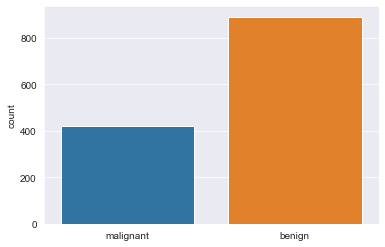

In [27]:
'''
  Display visualization amount of data normal and pneumonia
'''

l = []
for i in train:
    if(i[1] == 0):
        l.append("benign")
    else:
        l.append("malignant")
sns.set_style('darkgrid')
sns.countplot(l)

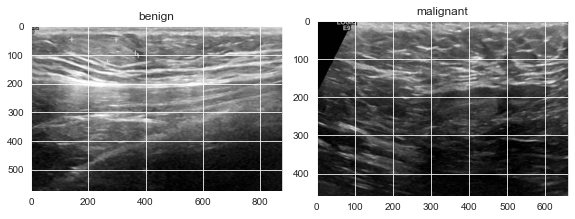

In [28]:
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

'''
  Display image from sample folder
'''

fig = plt.figure(figsize = (20,15))
ax = []
i = 1

new_dir = './data'

for image in os.listdir(new_dir):
    ax.append(fig.add_subplot(1,5,i))
    i += 1
    ax[-1].set_title(str(image))
    image_folder = os.path.join(new_dir, image)
    rnd_number = randint(0, len(os.listdir(image_folder)))
    image_file = os.listdir(image_folder)[rnd_number]
    image_file = os.path.join(image_folder, image_file)
    image_show = mpimg.imread(image_file)
    plt.imshow(image_show)

fig.tight_layout()
plt.show()

In [29]:
x_train = []
y_train = []
for features,label in train:
    x_train.append(features)
    y_train.append(label)

In [30]:
x_value = []
y_value = []
for features,label in val:
    x_value.append(features)
    y_value.append(label)

In [31]:
x_test = []
y_test = []
for features,label in test:
    x_test.append(features)
    y_test.append(label)

## Normalize Data

In [32]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_value) / 255
x_test = np.array(x_test) / 255

In [33]:
img_size = 50

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_value)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)



# Data Augmentation
* Data Augmentation simply means increasing the number of Data points. in terms of Images it means the increasing number of images in the Dataset.
* In order to avoid the overfitting problem, we need expand the dataset. This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc. The more the data, the better our models would perform.

More References :
* https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced

In [34]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [36]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 25, 25, 64)      

In [37]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.3, 
                              min_lr=0.000001)

In [38]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                                 epochs = 12 ,
                                 validation_data = datagen.flow(x_val, y_val),
                                 callbacks = [reduce_lr])

Epoch 1/12
41/41 [==============================] - 10s 192ms/step - loss: 1.0029 - accuracy: 0.6517 - val_loss: 0.6805 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 2/12
41/41 [==============================] - 9s 214ms/step - loss: 0.6379 - accuracy: 0.6875 - val_loss: 0.9048 - val_accuracy: 0.3209 - lr: 0.0010
Epoch 3/12
41/41 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.6989
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
41/41 [==============================] - 8s 190ms/step - loss: 0.5901 - accuracy: 0.6989 - val_loss: 0.7113 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 4/12
41/41 [==============================] - 7s 181ms/step - loss: 0.4911 - accuracy: 0.7668 - val_loss: 0.6439 - val_accuracy: 0.6791 - lr: 3.0000e-04
Epoch 5/12
41/41 [==============================] - 8s 188ms/step - loss: 0.4459 - accuracy: 0.8095 - val_loss: 0.6460 - val_accuracy: 0.6879 - lr: 3.0000e-04
Epoch 6/12
41/41 [==============================] - 7s 17

In [39]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1])

123/123 [==============================] - 3s 22ms/step - loss: 0.7918 - accuracy: 0.5526
Loss of the model is -  0.7917656898498535
123/123 [==============================] - 4s 32ms/step - loss: 0.7918 - accuracy: 0.5526
Accuracy of the model is -  0.5525914430618286


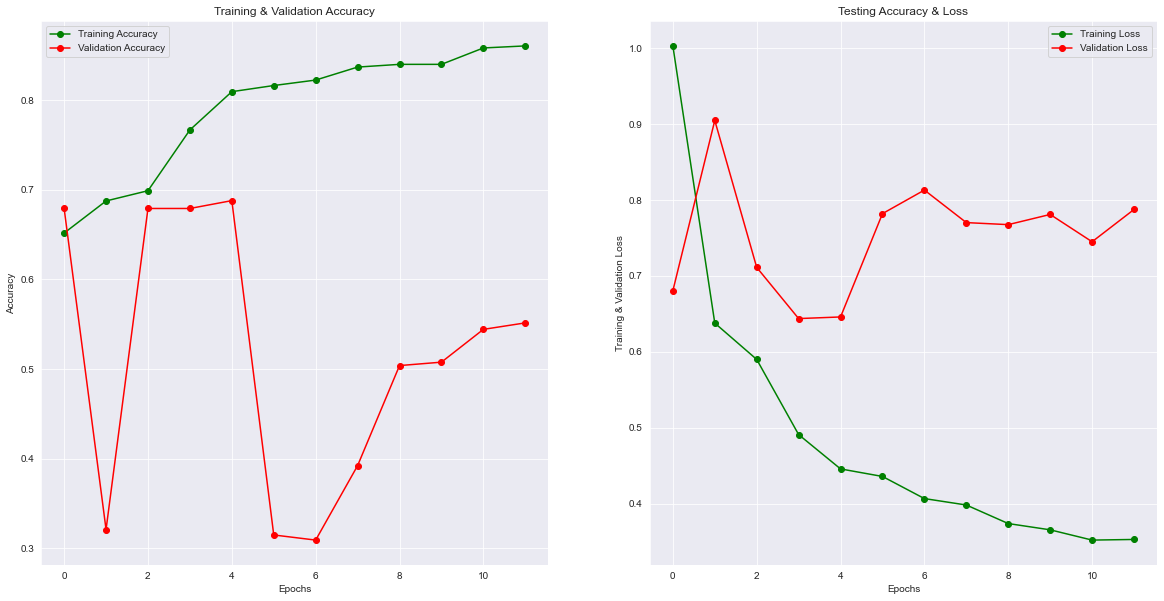

In [40]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [41]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

123/123 [==============================] - 4s 28ms/step


array([0.06955583, 0.52038956, 0.19084346, 0.6026175 , 0.7312174 ,
       0.14340517, 0.6420724 , 0.13567284, 0.59005994, 0.86149085,
       0.21513224, 0.16930349, 0.51090217, 0.47871625, 0.01958497],
      dtype=float32)

In [42]:
print(classification_report(y_test, predictions, target_names = ['Without Mask (Class 0)','With Mask (Class 1)'], digits=4))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [43]:
cm = confusion_matrix(y_test,predictions)
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [44]:
pred = model.predict(x_test)

123/123 [==============================] - 4s 33ms/step


In [23]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['With Mask', 'Without Mask'])
    df_cm2.columns=['With Mask', 'Without Mask']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()   
    return

In [24]:
#plot_heatmap((np.argmax(y_test,axis =1),predictions),'Face Mask Detection with CNN')

In [25]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

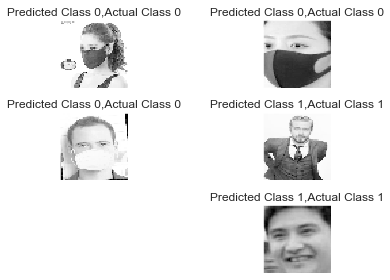

In [26]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(50,50), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [45]:
model.save('cnn2d_weights_2.h5')
model.load_weights('cnn2d_weights_2.h5')

In [47]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_5').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

41/41 [==============================] - 1s 23ms/step
(1312, 1)
123/123 [==============================] - 5s 37ms/step
(3936, 1)


In [48]:
pred = model.predict(x_test)

123/123 [==============================] - 4s 35ms/step


In [49]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

123/123 [==============================] - 4s 35ms/step


array([0.06955583, 0.52038956, 0.19084346, 0.6026175 , 0.7312174 ,
       0.14340517, 0.6420724 , 0.13567284, 0.59005994, 0.86149085,
       0.21513224, 0.16930349, 0.51090217, 0.47871625, 0.01958497],
      dtype=float32)

In [70]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(x_test),axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [50]:
confusion_matrix(y_test_arg,Y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [51]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [52]:
svm.score(feat_train,y_train)
svm.score(feat_test,y_test)
Pred_labels = svm.predict(feat_test)

In [53]:
print(classification_report(Pred_labels,y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9630    0.7109    0.8179      3621
           1     0.1710    0.6857    0.2738       315

    accuracy                         0.7088      3936
   macro avg     0.5670    0.6983    0.5458      3936
weighted avg     0.8996    0.7088    0.7744      3936



# Applying XGBOOST

In [54]:
import xgboost as xgb
xb = xgb.XGBClassifier()
xb.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [55]:
xb.score(feat_train,y_train)
xb.score(feat_test,y_test)
Pred_labels = xb.predict(feat_test)

In [56]:
print(classification_report(Pred_labels,y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9394    0.8110    0.8705      3096
           1     0.5368    0.8071    0.6448       840

    accuracy                         0.8102      3936
   macro avg     0.7381    0.8091    0.7577      3936
weighted avg     0.8535    0.8102    0.8223      3936



In [57]:
lr = LogisticRegression()
lr.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [58]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.6791    0.8089      3936
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6791      3936
   macro avg     0.5000    0.3396    0.4044      3936
weighted avg     1.0000    0.6791    0.8089      3936



C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
dt = DecisionTreeClassifier()
dt.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.9978    0.9989      2679
           1     0.9952    1.0000    0.9976      1257

    accuracy                         0.9985      3936
   macro avg     0.9976    0.9989    0.9982      3936
weighted avg     0.9985    0.9985    0.9985      3936



In [60]:
knn = KNeighborsClassifier()
knn.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.9035    0.7711    0.8320      3132
           1     0.4323    0.6791    0.5283       804

    accuracy                         0.7523      3936
   macro avg     0.6679    0.7251    0.6802      3936
weighted avg     0.8072    0.7523    0.7700      3936



In [61]:
lda = LinearDiscriminantAnalysis()
lda.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.6791    0.8089      3936
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6791      3936
   macro avg     0.5000    0.3396    0.4044      3936
weighted avg     1.0000    0.6791    0.8089      3936



C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
nb = GaussianNB()
nb.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.6791    0.8089      3936
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6791      3936
   macro avg     0.5000    0.3396    0.4044      3936
weighted avg     1.0000    0.6791    0.8089      3936



C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
et = ExtraTreesClassifier()
et.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.9978    0.9989      2679
           1     0.9952    1.0000    0.9976      1257

    accuracy                         0.9985      3936
   macro avg     0.9976    0.9989    0.9982      3936
weighted avg     0.9985    0.9985    0.9985      3936



In [64]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [65]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.8445    0.9157      3165
           1     0.6105    1.0000    0.7581       771

    accuracy                         0.8750      3936
   macro avg     0.8052    0.9223    0.8369      3936
weighted avg     0.9237    0.8750    0.8849      3936



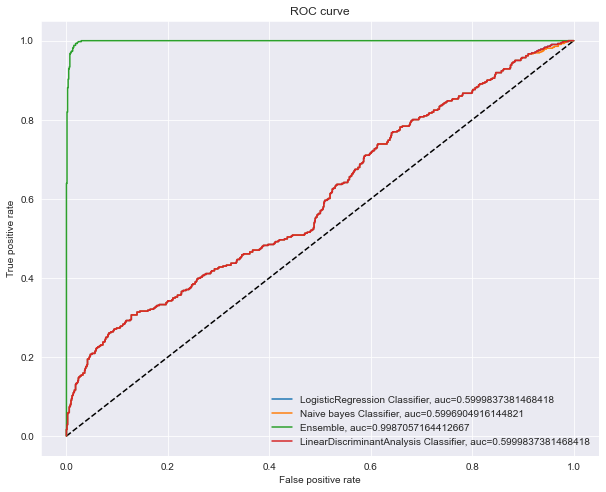

In [66]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,y_train)
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,y_train)
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,y_train)
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,y_train)
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()

# Using VGG16 Section

In [67]:
train_dir = "./Train"
test_dir = "./Test"
val_dir = "./data"

In [68]:
IMG_SIZE = 50#320

In [69]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16

vgg_model = VGG16(input_shape= (IMG_SIZE, IMG_SIZE,3), 
                  weights='imagenet',
                  include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 11001] getaddrinfo failed

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

vgg_output = vgg_model.output

flatten = Flatten()(vgg_output)
Dense_layer1 = Dense(units = 256,activation='relu')(flatten)
Dense_layer2 = Dense(units=128,activation='relu')(Dense_layer1)
Dense_layer3 = Dense(units = 64,activation='relu')(Dense_layer2)
output_layer = Dense(2,activation='sigmoid')(Dense_layer3)

In [ ]:
from keras.models import *

model = Model(inputs = vgg_model.input,
              outputs = output_layer)

In [ ]:
model.summary()

In [ ]:
import keras

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = False
)


image_generator_test = ImageDataGenerator(
     rescale = 1./255

)

In [ ]:
train = image_generator_train.flow_from_directory(train_dir, 
                                            batch_size=32,
                                            class_mode='categorical',
                                            target_size = (IMG_SIZE,IMG_SIZE))

validation = image_generator_test.flow_from_directory(test_dir, 
                                                batch_size=32,
                                                shuffle = True,
                                                class_mode='categorical',
                                                target_size = (IMG_SIZE,IMG_SIZE))

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

callback_list = ModelCheckpoint('vgg16_model_file.h5', 
                                 monitor='val_accuracy', 
                                 verbose=True, 
                                 save_best_only=True)

In [ ]:
r = model.fit(
    train,
    epochs = 15,
    validation_data = validation,
    validation_steps = len(validation),
    steps_per_epoch = 100,
    callbacks = [callback_list]
)

In [ ]:
my_model = keras.models.load_model('./vgg16_model_file.h5')

test_pred = []
test_actual = []
label_dict = {
    0 : "with_mask",
    1 : "without_mask"
}

normal_path = './Test/with_mask'
pneumonia_path = './Test/without_mask'

In [ ]:
my_model.evaluate_generator(train,steps = 32,verbose = 1)

In [ ]:
my_model.evaluate_generator(validation,steps = 32, verbose = 1)